### Install Dependencies

In [1]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00


In [2]:
pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import glob

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fine-tune TrOCR

We will do this using the new `VisionEncoderDecoderModel` class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa. The weights of the cross-attention layer were randomly initialized, before the authors pre-trained the model further on millions of (partially synthetic) annotated images of handwritten text.

* TrOCR paper: https://arxiv.org/abs/2109.10282
* TrOCR documentation: https://huggingface.co/transformers/master/model_doc/trocr.html


Note that Patrick also wrote a very good [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder) on warm-starting encoder-decoder models (which is what the TrOCR authors did). This blog post was very helpful for me to create this notebook.

We will fine-tune the model using the Seq2SeqTrainer, which is a subclass of the 🤗 Trainer that lets you compute generative metrics such as BLEU, ROUGE, etc by doing generation (i.e. calling the `generate` method) inside the evaluation loop.


### Prepare data

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/SATRIA_DATA/AUGMENTASI_SATRIA/label_4000data_murni.csv')
df.columns

Index(['Unnamed: 0', 'NameofFile', 'Vehicleregistrationplate'], dtype='object')

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/SATRIA_DATA/DataTest_Folder/DataTest.csv', sep=';')
df_test.columns

Index(['Unnamed: 0', 'Name of File'], dtype='object')

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df_test.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df_test.columns = ['NameofFile']
df_test['Vehicleregistrationplate'] = '-'

df['NameofFile'] = df['NameofFile'] + '.png'

df_test = df_test[['Vehicleregistrationplate', 'NameofFile']]
df = df[['Vehicleregistrationplate', 'NameofFile']]

In [ ]:
df = df.sample(frac=1, random_state=42)
df.reset_index(drop=True, inplace=True)
df

,Vehicleregistrationplate,NameofFile
0,B1819CKF,DataTrain52_3530.png
1,B1840TJK,DataTrain311_1587.png
2,B1326RFD,DataTrain99_3835.png
3,AIIS,DataTrain127_3978.png
4,AB1449DH,DataTrain579_3693.png
...,...,...
4286,B1618WYJ,DataTrain16_3445.png
4287,B1963TFU,DataTrain696_467.png
4288,B123MBM,DataTrain436_3093.png
4289,B1817UL,DataTrain718_3773.png


In [ ]:
df_test

,Vehicleregistrationplate,NameofFile
0,-,DataTest1.png
1,-,DataTest2.png
2,-,DataTest3.png
3,-,DataTest4.png
4,-,DataTest5.png
...,...,...
95,-,DataTest96.png
96,-,DataTest97.png
97,-,DataTest98.png
98,-,DataTest99.png


In [ ]:
df.Vehicleregistrationplate.value_counts()

B1819CKF    7
B1314PVF    7
AD9313SS    7
B1697SJO    7
B1274BJB    7
           ..
B1898STA    7
AB6923UE    7
B15MAH      7
B1961OA     7
B1617QZ     7
Name: Vehicleregistrationplate, Length: 613, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=0, stratify=df['Vehicleregistrationplate'])
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df.Vehicleregistrationplate.value_counts()

B1669TFL    6
B1388FOC    6
AD9112BZ    6
AB1473RI    6
B1895WLT    6
           ..
B1079ZKM    5
B1160RFK    5
B1324EON    5
B1820UL     5
B1210DFO    5
Name: Vehicleregistrationplate, Length: 613, dtype: int64

In [ ]:
val_df.Vehicleregistrationplate.value_counts()

AA510LE     2
B1404GT     2
B1830DFD    2
AD6259QQ    2
B1617RFP    2
           ..
B1855SLO    1
B1169TJK    1
B1278EJ     1
B1157SSL    1
B15MAH      1
Name: Vehicleregistrationplate, Length: 613, dtype: int64

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class PlatDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=9):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['NameofFile'][idx]
        text = self.df['Vehicleregistrationplate'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1")
train_dataset = PlatDataset(root_dir='/content/drive/MyDrive/SATRIA_DATA/AUGMENTASI_SATRIA/AUGMENTASI_4000/',
                           df=train_df,
                           processor=processor)
eval_dataset = PlatDataset(root_dir='/content/drive/MyDrive/SATRIA_DATA/AUGMENTASI_SATRIA/AUGMENTASI_4000/',
                           df=val_df,
                           processor=processor)
test_dataset = PlatDataset(root_dir='/content/drive/MyDrive/SATRIA_DATA/DataTest_Folder/DataTest_Images/',
                           df=df_test,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 3432
Number of validation examples: 859


Let's verify an example from the training dataset:

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([9])


We can also check the original image and decode the labels:

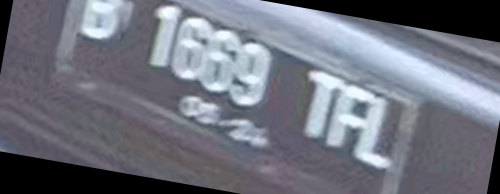

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['NameofFile'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

B1669TFL


## Finetune the pretrained model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 9
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 1
model.config.num_beams = 4

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    output_dir="./",
    logging_steps=20,
    save_steps=1000,
    eval_steps=200,
)

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-28-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

In [ ]:
predictions = trainer.evaluate(eval_dataset)

In [ ]:
predictions['eval_loss']

In [ ]:
# Save the trained model using the trainer
trainer.save_model("/content/drive/MyDrive/SATRIA_DATA/model_base_modify_augmented4k_surya_batch16")

## Predict Images

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/SATRIA_DATA/model_base_modify_augmented4k_surya_length1")

In [ ]:
encoding = eval_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([9])


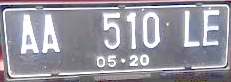

In [ ]:
image = Image.open(eval_dataset.root_dir + val_df['NameofFile'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

AA510LE


In [ ]:
pixel_values = processor(image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (9) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


AA510LE


## Evaluate Data Test

In [ ]:
df_test_labeled = pd.read_csv('/content/drive/MyDrive/SATRIA_DATA/DataTest_Folder/Labeled_DataTest.csv')
df_test_labeled.drop('Gambar', axis=1, inplace=True)
df_test_labeled.drop('Unnamed: 2', axis=1, inplace=True)
df_test_labeled['NameofFile'] = df_test['NameofFile']

In [ ]:
df_test_labeled = df_test_labeled[['NameofFile', 'Label']]
df_test_labeled

,NameofFile,Label
0,DataTest1.png,AD7034OE
1,DataTest2.png,A9388EX
2,DataTest3.png,B16TB
3,DataTest4.png,B1661TKZ
4,DataTest5.png,AD3772ABE
...,...,...
95,DataTest96.png,B1285QL
96,DataTest97.png,AB8644PK
97,DataTest98.png,AG9718EG
98,DataTest99.png,B1509UN


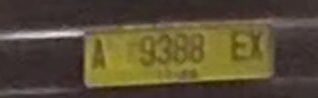

In [ ]:
image = Image.open(test_dataset.root_dir + df_test['NameofFile'][1]).convert("RGB")
image

In [ ]:
pixel_values = processor(image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (9) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


A9388EX


In [ ]:
from tqdm import tqdm
predicted_labels = []

iterable = tqdm(df_test.iterrows(), total=len(df_test), desc="Processing", unit="image")
for index, row in iterable:
    # Load and preprocess the image
    image = Image.open(test_dataset.root_dir + row['NameofFile']).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Generate predictions
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predicted_labels.append(generated_text)


Processing: 100%|██████████| 100/100 [17:25<00:00, 10.45s/image]


In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

# Calculate the CER score
cer = cer_metric.compute(predictions=predicted_labels, references=df_test_labeled['Label'])

# Print the CER score
print(cer)

0.035479632063074903


In [ ]:
df_test_labeled['Predicted'] = predicted_labels

In [ ]:
df_test_labeled.to_csv('/content/drive/MyDrive/SATRIA_DATA/DataTest_Folder/Prediction_DataTest_modify_length1.csv', index=False)

## Compare the Problemed Image

In [ ]:
df_test_diff = df_test_labeled.loc[df_test_labeled['Label'] != df_test_labeled['Predicted']]
df_test_diff = df_test_diff.reset_index()
df_test_diff.drop('index', axis=1, inplace=True)
df_test_diff

,NameofFile,Label,Predicted
0,DataTest1.png,AD7034OE,AD7034QE
1,DataTest6.png,B2271BV,B1271VY
2,DataTest20.png,B13QO,B17QO
3,DataTest21.png,AB6328LZ,AB6638Z
4,DataTest22.png,B1236PZN,B1236PZH
5,DataTest29.png,AD8820CB,AD8400CB
6,DataTest31.png,B8120KXT,B0120KXT
7,DataTest33.png,B1390TJU,B1390TJD
8,DataTest41.png,AB4923UH,AB4923QH
9,DataTest44.png,B202UL,B1202UL


In [ ]:
df_test_diff.shape

(21, 3)

In [ ]:
problem_image_list = []
iterable = tqdm(df_test_diff.iterrows(), total=len(df_test_diff), desc="Processing", unit="image")
for index, row in iterable:
  image = Image.open(test_dataset.root_dir + row['NameofFile']).convert("RGB")
  problem_image_list.append(image)

Processing: 100%|██████████| 21/21 [00:00<00:00, 324.69image/s]


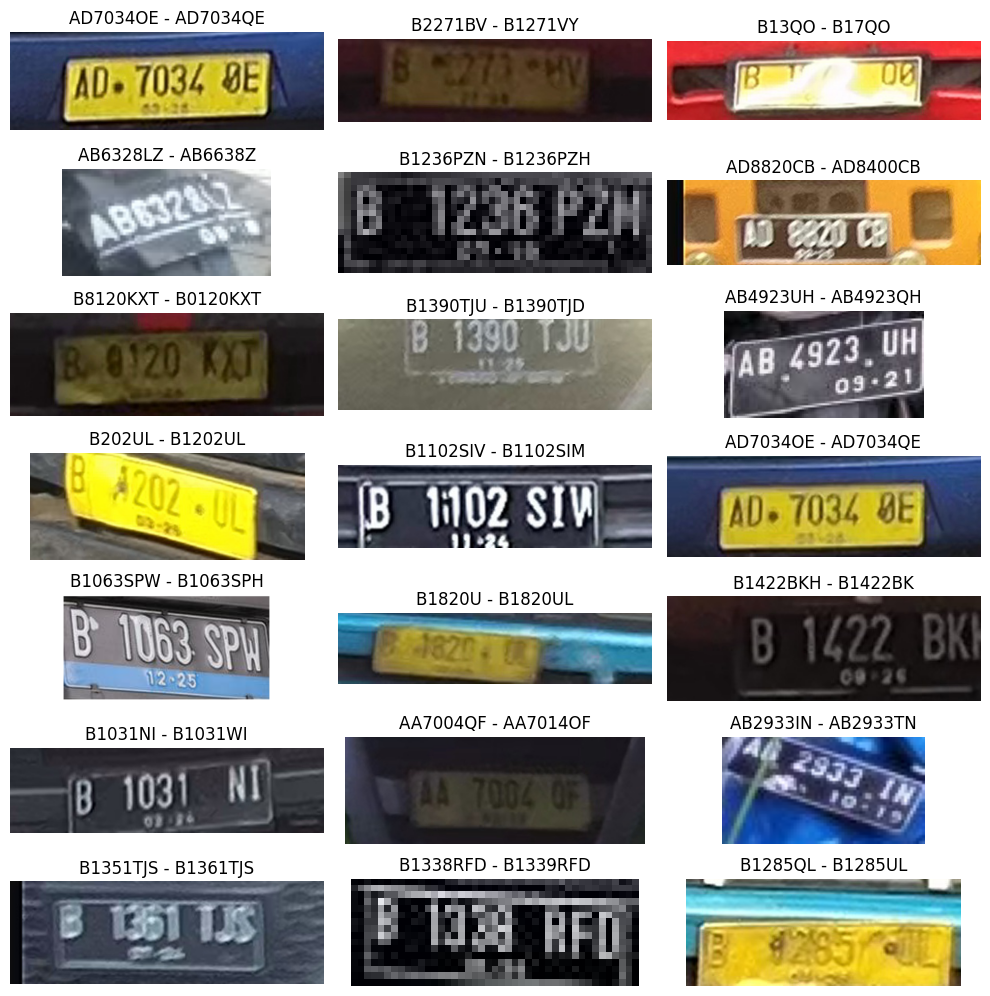

In [ ]:
import matplotlib.pyplot as plt

def display_images(image_list, label1_list, label2_list):
    num_images = len(image_list)
    num_rows = 7  # Number of rows in the grid
    num_cols = 3  # Number of columns in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))  # Adjust the figsize as needed

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(image_list[index])
                axes[i, j].axis('off')
                axes[i, j].set_title(f"{label1_list[index]} - {label2_list[index]}")  # Set the title with both labels

    plt.tight_layout()
    plt.show()

# Assuming you have a list of images called 'problem_image_list'
# and two lists of labels called 'label1_list' and 'label2_list'
# (with corresponding labels for each image)
display_images(problem_image_list, df_test_diff['Label'], df_test_diff['Predicted'])

# LIHAT HASIL DATA VAL

In [ ]:
val_df.head()

,Vehicleregistrationplate,NameofFile
0,AA510LE,DataTrain610_770.png
1,AA1248MB,DataTrain272_3414.png
2,AA8144CF,DataTrain94_628.png
3,B1783NKV,DataTrain174_256.png
4,B1470TLO,DataTrain640_4132.png


In [ ]:
from tqdm import tqdm
predicted_labels = []

iterable = tqdm(val_df.iterrows(), total=len(val_df), desc="Processing", unit="image")
for index, row in iterable:
    # Load and preprocess the image
    image = Image.open(eval_dataset.root_dir + row['NameofFile']).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Generate predictions
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predicted_labels.append(generated_text)

In [ ]:
val_df['Predicted'] = predicted_labels
val_df.to_csv('/content/drive/MyDrive/SATRIA_DATA/DataTest_Folder/Prediction_DataVal4k_surya.csv', index=False)

In [ ]:
df_val_diff = val_df.loc[val_df['Vehicleregistrationplate'] != val_df['Predicted']]
df_val_diff = df_val_diff.reset_index()
df_val_diff.drop('index', axis=1, inplace=True)
df_val_diff

In [ ]:
problem_image_list = []
iterable = tqdm(df_val_diff.iterrows(), total=len(df_val_diff), desc="Processing", unit="image")
for index, row in iterable:
  image = Image.open(eval_dataset.root_dir + row['NameofFile']).convert("RGB")
  problem_image_list.append(image)

# LIHAT HASIL DATA TRAIN

In [ ]:
train_df.head()

In [ ]:
from tqdm import tqdm
predicted_labels = []

iterable = tqdm(train_df.iterrows(), total=len(train_df), desc="Processing", unit="image")
for index, row in iterable:
    # Load and preprocess the image
    image = Image.open(train_dataset.root_dir + row['NameofFile']).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Generate predictions
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predicted_labels.append(generated_text)

In [ ]:
train_df['Predicted'] = predicted_labels
train_df.to_csv('/content/drive/MyDrive/SATRIA_DATA/DataTest_Folder/Prediction_DataTrain4k_surya.csv', index=False)

In [ ]:
df_train_diff = train_df.loc[train_df['Vehicleregistrationplate'] != train_df['Predicted']]
df_train_diff = df_train_diff.reset_index()
df_train_diff.drop('index', axis=1, inplace=True)
df_train_diff

In [ ]:
problem_image_list = []
iterable = tqdm(df_train_diff.iterrows(), total=len(df_train_diff), desc="Processing", unit="image")
for index, row in iterable:
  image = Image.open(train_dataset.root_dir + row['NameofFile']).convert("RGB")
  problem_image_list.append(image)